In [27]:
# IMPORTS
import torch
import numpy as np
import scipy.special
import h5py
import random
import matplotlib.pyplot as plt
import torchvision.transforms.functional as TF
from torch import nn
import tifffile
from PIL import Image
import torch.nn.functional as F

### Preliminary Steps

In [28]:
## HELPER FUNCTIONS
def calculate_phi(NPXLS):
    N= (NPXLS-1)/2
    A= torch.arange(-N, N+1)

    XX = torch.unsqueeze(A, dim= 0)
    YY = -torch.unsqueeze(A, dim= 1)

    X= torch.tile(XX, (NPXLS, 1))
    Y= torch.tile(YY, (1, NPXLS))

    phi = torch.atan2(Y, X)
    return phi

# 3D Convolution
def conv_3D(PSF_3D, H):

    Ht_fft = torch.fft.fftshift(torch.fft.fftn(torch.fft.ifftshift(H, dim =(-3, -2, -1)), dim =(-3, -2, -1)), dim =(-3, -2, -1))
    PSF_fft = torch.fft.fftshift(torch.fft.fftn(torch.fft.ifftshift(PSF_3D, dim =(-3, -2, -1)), dim =(-3, -2, -1)), dim =(-3, -2, -1))
    conv_PSF_H = torch.fft.fftshift(torch.fft.ifftn(torch.fft.ifftshift(PSF_fft * Ht_fft, dim =(-3, -2, -1)), dim =(-3, -2, -1)), dim =(-3, -2, -1))
    
    return conv_PSF_H


# VISUALIZING PSF
def show_psf(PSF_3D):
    _, Nx, Ny, Nz = PSF_3D.shape

    plt.figure(figsize = (12, 3))
    plt.subplot(1,3,1)
    plt.imshow(PSF_3D[0, :, :, Nz//2].abs())
    plt.title('x-axis')
    plt.colorbar(fraction = 0.025)

    plt.subplot(1,3,2)
    plt.imshow(PSF_3D[1, :, :, Nz//2].abs())
    plt.title('y-axis')
    plt.colorbar(fraction = 0.025)

    plt.subplot(1,3,3)
    plt.imshow(PSF_3D[2, :, :, Nz//2].abs())
    plt.title('z-axis')
    plt.colorbar(fraction = 0.025)

    plt.suptitle('3D PSF : ABS', y= 1.01)
    plt.show()


    plt.figure(figsize = (12, 3))
    plt.subplot(1,3,1)
    plt.imshow(PSF_3D[0, :, :, Nz//2].angle())
    plt.title('x-axis')
    plt.colorbar(fraction = 0.025)

    plt.subplot(1,3,2)
    plt.imshow(PSF_3D[1, :, :, Nz//2].angle())
    plt.title('y-axis')
    plt.colorbar(fraction = 0.025)

    plt.subplot(1,3,3)
    plt.imshow(PSF_3D[2, :, :, Nz//2].angle())
    plt.title('z-axis')
    plt.colorbar(fraction = 0.025)

    plt.suptitle('3D PSF : ANGLE', y= 1.01)
    plt.show()

# SHOWING PLANES OF 3D TENSOR
def show_planes(outs, title, N_z = 256): #outs.shape: [Nz, Nx, Ny]
    z_planes= range(0, N_z, N_z//8)
    plt.figure(figsize= (20, 2))
    for i, z_idx in enumerate(z_planes):
        plt.subplot(1, len(z_planes), i+1)
        plt.imshow(outs[z_idx], vmin= outs.min(), vmax= outs.max())
        plt.axis('off')
        plt.title(f'z: {z_idx}')

    plt.subplots_adjust(top=0.73)
    plt.suptitle(f'{title} | min: {round(outs.min(), 2)}, max: {round(outs.max(), 2)}\n')
    plt.show()

# SHOWING 2D IMAGES
def show_image(image, title='', fig_size = (5,5)):
    plt.figure(figsize=fig_size)
    plt.imshow(image)
    plt.xticks([])
    plt.yticks([])
    plt.title(title)
    plt.show()


class psf_model(nn.Module):
    def __init__(self, NA, Rindex, lambda_, dx, Nx, Ny, Nz):
        super().__init__()
        self.NA= NA
        self.Rindex = Rindex
        self.lambda_ = lambda_
        self.dx= dx
        self.Nx = Nx
        self.Ny = Ny
        self.Nz = Nz
        self.Ntheta= 400 # n grid in polar angle

        self.abberations=  torch.nn.Parameter(torch.zeros((self.Ntheta, )).float())

        self.init_psf_params()

    def init_psf_params(self):
        self.alpha = np.arcsin(self.NA/ self.Rindex)
        self.dy= self.dx
        self.dz= self.dx


        self.x = self.dx * torch.arange(-self.Nx//2+1, self.Nx//2+1)
        self.y = self.dy * torch.arange(-self.Ny//2+1, self.Ny//2+1)
        self.z = self.dz * torch.arange(-self.Nz//2+1, self.Nz//2+1)

        self.dtheta = self.alpha/ self.Ntheta
        self.theta = torch.arange(0, self.Ntheta)*self.dtheta

        assert self.Nx== self.Ny, "self.Nx != self.Ny -> self.Phi calculation wrong !!!"
        self.Phi= calculate_phi(self.Nx)
        self.A= np.pi/ self.lambda_

        self.X, self.Y, self.THETA = torch.meshgrid(self.x, self.y, self.theta)

        V= (2*np.pi/ self.lambda_)* torch.sqrt(self.X**2 + self.Y**2).numpy() #k.r
        J0= torch.from_numpy(scipy.special.jv(0, V* np.sin(self.THETA.numpy())))
        J1= torch.from_numpy(scipy.special.jv(1, V* np.sin(self.THETA.numpy())))
        J2= torch.from_numpy(scipy.special.jv(2, V* np.sin(self.THETA.numpy())))

        self.Func0 = torch.sqrt(torch.cos(self.THETA))* torch.sin(self.THETA) * (1+ torch.cos(self.THETA)) * J0
        self.Func1 = torch.sqrt(torch.cos(self.THETA))* (torch.sin(self.THETA)**2) * J1
        self.Func2 = torch.sqrt(torch.cos(self.THETA))* torch.sin(self.THETA) * (1- torch.cos(self.THETA)) * J2

        self.U = 2*np.pi/ self.lambda_ * self.z # k.z


    def forward(self):
        device= self.abberations.device
        ABBR = torch.tile(self.abberations, (self.x.shape[0], self.y.shape[0], 1))

        Func0 = self.Func0.to(device) *torch.exp(1j * ABBR)
        Func1 = self.Func1.to(device) *torch.exp(1j * ABBR)
        Func2 = self.Func2.to(device) *torch.exp(1j * ABBR)

        PSF_3D = torch.zeros((3, self.Nx, self.Ny, self.Nz), dtype = torch.cfloat).to(device)

        for k in range(len(self.U)):
            Func3_atThisU = torch.exp(-1j * self.U[k] * torch.cos(self.THETA)).to(device)

            I0 = torch.trapz(y= Func0 * Func3_atThisU, x= self.theta.to(device), axis= 2) #axis: alpha
            I1 = torch.trapz(y= Func1 * Func3_atThisU, x= self.theta.to(device), axis= 2) #axis: alpha
            I2 = torch.trapz(y= Func2 * Func3_atThisU, x= self.theta.to(device), axis= 2) #axis: alpha

            Ex = 1j * self.A * (I0 + I2 * torch.cos(2*self.Phi.to(device)))
            Ey = 1j * self.A * I2 * torch.sin(2*self.Phi.to(device))
            Ez = (-2) * self.A* I1 * torch.cos(self.Phi.to(device))

            # Es = 1j * A * I0 ## scalar approx
            PSF_3D[0, :, :, k] = Ex
            PSF_3D[1, :, :, k] = Ey
            PSF_3D[2, :, :, k] = Ez

        return PSF_3D

        #IPSF = (PSF_3D.abs()**2).sum(dim= 0)
        #IPSF = IPSF/ torch.sqrt((IPSF**2).sum())
        #return IPSF.permute(2,0,1).unsqueeze(dim=0) #channel first, add batch dim

### Parameters

In [29]:
# Parameter Definition
NA = 1.3
Rindex= 1.518
lambda_= 532.0/ 1000 #um
dx= 0.1 #um

Nx,Ny,Nz = 101,101,101
device= torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [30]:
# INITIALIZATION
psf = psf_model(NA, Rindex, lambda_, dx, Nx,Ny,Nz).to(device)
exPSF_3D = psf().detach().permute(0,3,1,2)
emPSF_3D = (exPSF_3D.abs()**2).sum(dim= 0).unsqueeze(dim= 0) #IPSF

### Forward Model

$$ H_1(x,y,z) = H(x,y,z=z_f)\ \star_{\tiny 3D}\ \texttt{exPSF}(x,y,z) \qquad\to\qquad H_2(x,y,z) = \|H_1(x,y,z)\|$$ 



$$H_3(x,y,z) = X(x,y,z) \circ H_2(x,y,z) \qquad \to \qquad Y(x,y,z) = \texttt{emPSF}(x,y,z)\ \star_{\tiny 3D}\ H_3(x,y,z)$$

The $\texttt{exPSF}(.)$ is modelled considering the coherance nature of laser light whereas the $\texttt{emPSF}(.)$ is defined in a incoherant manner<br>

[Image Data](https://bigwww.epfl.ch/deconvolution/bead/)

In [31]:
def forward_model(X, ht_2D,verbose = 0):
    ht_3D = torch.zeros(1, Nz, Nx, Ny).float().to(device)
    ht_3D[:, Nz //2] = ht_2D
    H1 = conv_3D(exPSF_3D, ht_3D)
    H2 = (H1.abs()**2).sum(dim= 0)

    # OPERATIONS
    H3 = X * H2
    Y = conv_3D(emPSF_3D, H3).abs()[0]
    det_Y = Y[round(Nz/2),:,:]
    
    # Excitation Pattern Convolved with Coherent PSF : H2
    coherent_out = H2.detach().cpu().numpy()
    # Normalized Image : X
    I = X[0].detach().cpu().numpy()
    
    # Image at Camera: Y
    R = Y.detach().cpu().numpy()

    # Image at Detector: ~Y
    det_R = det_Y.detach().cpu().numpy()

    if verbose==1:
        show_image(ht_2D, "Excitation Pattern",fig_size = (3,3))
        show_planes(coherent_out, title= f'H2 (Nx:{Nx},Ny:{Ny},Nz:{Nz})', N_z=Nz)
        show_planes(I, title = f"Image",N_z=Nz)
        show_planes(R, title= f'Y (Nx:{Nx},Ny:{Ny},Nz:{Nz})',N_z=Nz)
        show_image(det_R, "Detected Image",(3,3))
    if verbose ==2:
        show_planes(I, title = f"Image",N_z=Nz)
        show_image(det_R, "Detected Image",(3,3))


    return det_Y
    

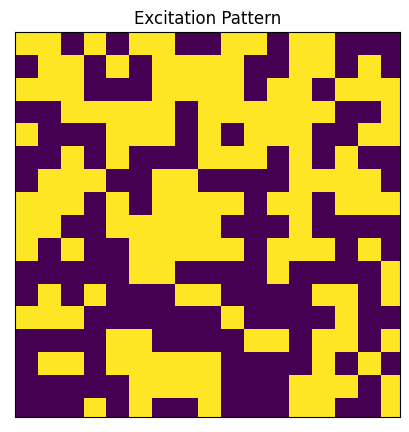

In [32]:
patch_size= max(min(Nx,Ny)//20,1)
Ht_2D= (torch.randn(Nx//patch_size, Ny//patch_size)>0).float()
Ht_2D = Ht_2D.repeat_interleave(patch_size+1, dim= 0).repeat_interleave(patch_size+1, dim= 1)[:Nx, :Ny]
show_image(Ht_2D, "Excitation Pattern",fig_size = (5,5))

### Bead

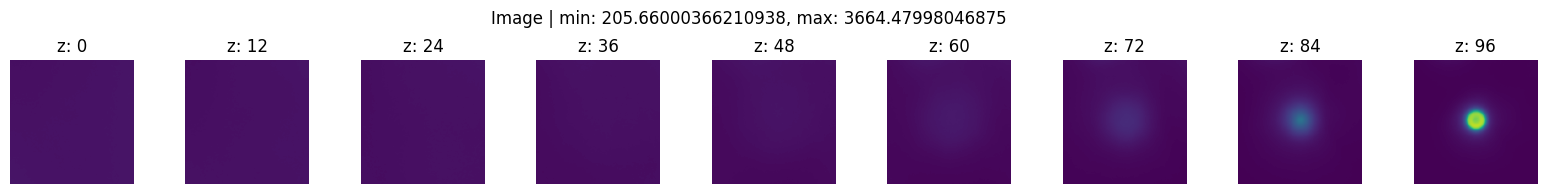

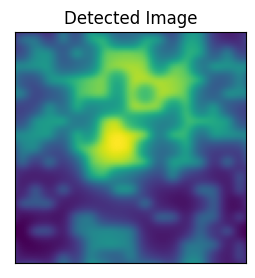

In [33]:
# READING THE IMAGE
X = torch.zeros(1, Nz, Nx, Ny).float().to(device)

Iz = 201
low_l, up_l = round((Iz-Nz)/2), round((Iz+Nz)/2)
low_l -= 1 if up_l - low_l != Nz else 0


for slice_index in range(low_l,up_l):
    image_path = f'./data/Bead/z{slice_index:04d}.tif'  # Update the path accordingly
    image = tifffile.imread(image_path).astype(float)  # Read image as float
    assert image is not None
    r_image = torch.tensor(np.array(Image.fromarray(image).resize((Nx, Ny)))).to(device)
    
    # Store the image data in the tensor
    X[0,slice_index-low_l, :, :] = r_image

_=forward_model(X,Ht_2D,2)

### 3D Objects

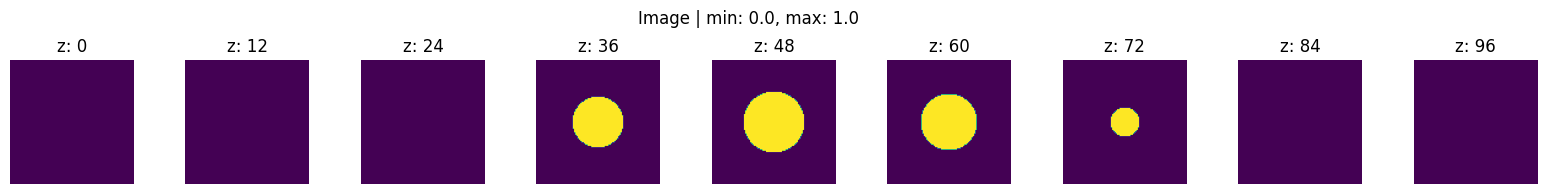

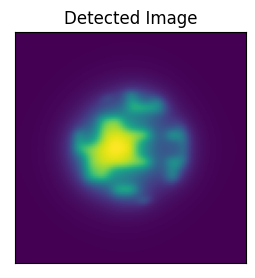

In [34]:
# Create a grid of points in the 3D tensor space
x = torch.linspace(-1, 1, Nx)
y = torch.linspace(-1, 1, Ny)
z = torch.linspace(-1, 1, Nz)

# Create a meshgrid from the points
x, y, z = torch.meshgrid(z,x,y)

# Define the center and radius of the sphere
center = torch.tensor([0.0, 0.0, 0.0])
radius = 0.5

# Calculate the distance from each point in the grid to the center
distance = torch.sqrt((x - center[0])**2 + (y - center[1])**2 + (z - center[2])**2)

# Create a mask to identify points inside the sphere
inside_sphere = distance <= radius
inside_sphere = inside_sphere.unsqueeze(0)
# Initialize a 3D tensor with zeros and set the values inside the sphere to white (1.0)
spherical_object = torch.zeros(1,Nz, Nx, Ny).float().to(device)
spherical_object[inside_sphere] = 1.0


_=forward_model(spherical_object,Ht_2D,2)


### Blood Vessels Raw Data


In [35]:
with h5py.File('./data/Deep2/BV_03102021.mat', 'r') as mat_file:
    Data = mat_file['Data']['cell']
    Data = Data[:]

raw_data = torch.from_numpy(Data).to(device)

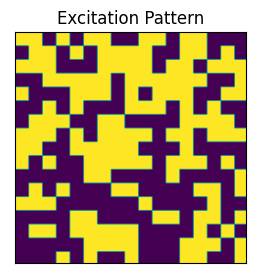

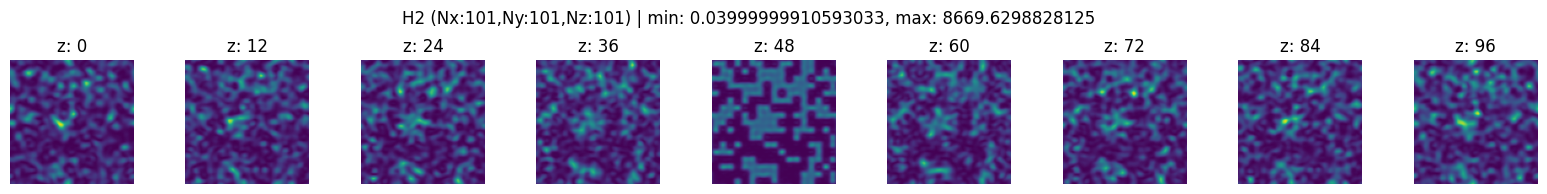

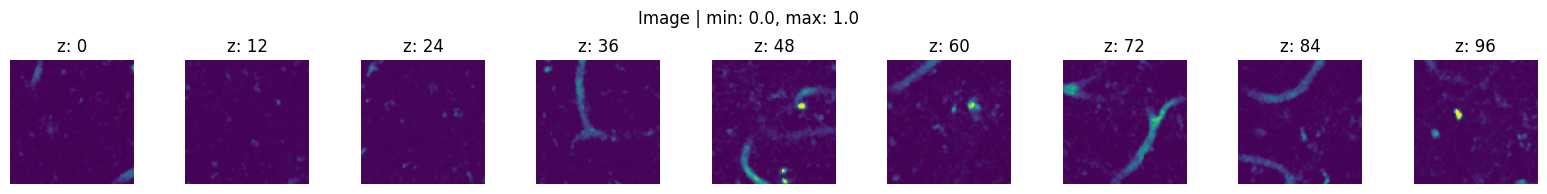

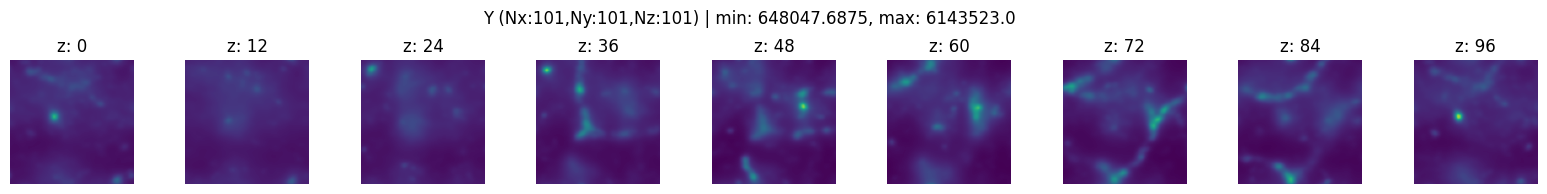

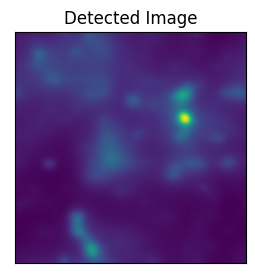

In [37]:
# Your original tensor size
tensor_size = raw_data.shape
raw_data = (raw_data - raw_data.min())/(raw_data.max()-raw_data.min())                # NORMALIZATION

# Generate random coordinates within valid range
x_start = random.randint(0, tensor_size[0] - Nx)
y_start = random.randint(0, tensor_size[1] - Ny)
z_start = random.randint(0, tensor_size[2] - Nz)

# Extract the cube
random_cube = raw_data[z_start:z_start+Nz,x_start:x_start+Nx, y_start:y_start+Ny]

random_cube = random_cube.unsqueeze(0)
_=forward_model(random_cube,Ht_2D,1)

### Neural Raw Data

In [38]:
with h5py.File('./data/Deep2/PS_SOM_mice_20190317.mat', 'r') as mat_file:
    Data = mat_file['Data']['cell']
    out = Data[3,0]
    arr = mat_file[out][:]
raw_data = torch.from_numpy(arr).float().to(device)

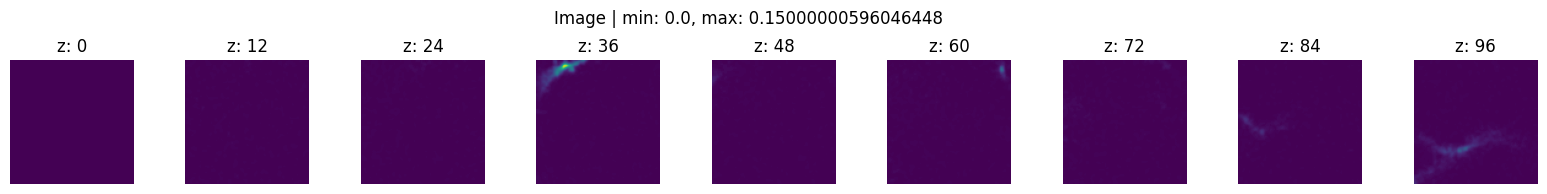

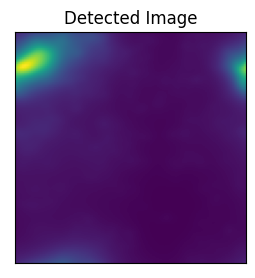

In [43]:
# Your original tensor size
tensor_size = raw_data.shape
raw_data = (raw_data - raw_data.min())/(raw_data.max()-raw_data.min())                # NORMALIZATION

# Generate random coordinates within valid range
x_start = random.randint(0, tensor_size[1] - Nx)
y_start = random.randint(0, tensor_size[2] - Ny)
z_start = random.randint(0, tensor_size[0] - Nz)

# Extract the cube
random_cube = raw_data[z_start:z_start+Nz, x_start:x_start+Nx, y_start:y_start+Ny]


random_cube = random_cube.unsqueeze(0)
_=forward_model(random_cube,Ht_2D,2)

## Approximation of A

$$Y_{\tiny N_x\cdot N_y\cdot m\times1} = A_{\tiny N_x\cdot N_y\cdot m\times N_x\cdot N_y\cdot N_z}\cdot X_{\tiny N_x\cdot N_y\cdot N_z\times 1}$$

In [ ]:
m = 32
A = torch.zeros(Nx*Ny*m,Nx*Ny*Nz).float().to(device)

In [ ]:
# Lets Fix Ht ~ # = m

Ht_2D_list = []

for _ in range(m):
    patch_size = max(min(Nx, Ny) // 20,1)
    Ht_2D = (torch.randn(Nx // patch_size, Ny // patch_size) > 0).float()
    Ht_2D = Ht_2D.repeat_interleave(patch_size + 1, dim=0).repeat_interleave(patch_size + 1, dim=1)[:Nx, :Ny]
    Ht_2D_list.append(Ht_2D)

# Ht_2D_tensor = torch.stack(Ht_2D_list, dim=0)

In [ ]:

def extended_forward_model(X):
    Y = torch.tensor([]).to(device)
    for Ht_2D in Ht_2D_list:
        Yi = forward_model(X,Ht_2D)
        Yi_flatten = Yi.flatten()
        Y = torch.cat((Y, Yi_flatten), dim=0)
    return Y

In [ ]:
I = torch.zeros(1, Nz, Nx, Ny).float().to(device)
for i_z in range(Nz):
    for i_x in range(Nx):
        for i_y  in range(Ny):
            I[0,i_z,i_x,i_y] = 1
            A [:,i_z*Ny*Nx+ i_x*Ny+i_y] = extended_forward_model(I)
            I[0,i_z,i_x,i_y] = 0

***Visualization of A***

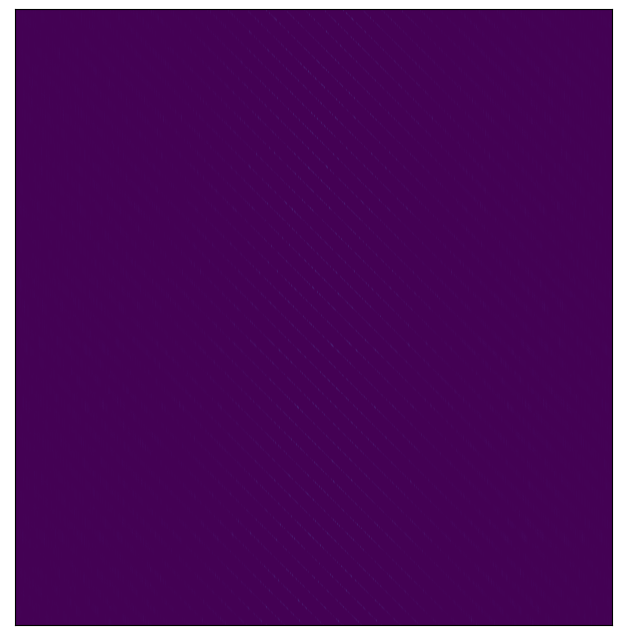

In [ ]:
show_image(A.detach().cpu().numpy(),fig_size=(8,8))

***Verification of A***

In [ ]:
Y1 = extended_forward_model(random_cube)
Y2 = torch.matmul(A,random_cube.flatten())

tolerance = 1e-6
are_approx_equal = torch.allclose(Y1, Y2, atol=tolerance)

if are_approx_equal:
    print("The vectors are approximately the same.")
else:
    print("The vectors are different.")

The vectors are approximately the same.
